In [1]:
# imports
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotting as myP
import numpy as np
import csv 
import match

In [2]:
# path variables 
path_cat = 'D:\IfA REU\Catalogs'
path_fig = 'D:\IfA REU\IfA-REU-Project\Figures'
path_csv = 'D:\IfA REU\IfA-REU-Project\Lists'

# Get AGN IDs

In [3]:
# read from a given csv file and return a list of its contents 
def ReadFile(filename) : 
    # initialize list
    file = []

    # open csv file
    with open(path_csv+filename, newline='') as csv_file : 
        reader = csv.reader(csv_file, delimiter=',', quotechar='"')
        # output file into list for easy access
        for row in reader :
            file.append(row)

    # print column names 
    print(filename, ' columns: ', file[0])

    # return an array of type int with column names clipped off
    return( np.array(file[1:], dtype=int) )


In [4]:
# read AGN ID and index from csv files
agn_irSel = ReadFile('\Match_COSMOS2020_IRAGN_to_COSMOS2020.csv')
agn_xrSel = ReadFile('\Match_Chandra2016_XrayAGN_to_COSMOS2020.csv')

# transpose arrays to get columns
agn_irSel_id, agn_irSel_i = agn_irSel.T
agn_xrSel_id, agn_xrSel_i = agn_xrSel.T

\Match_COSMOS2020_IRAGN_to_COSMOS2020.csv  columns:  ['ID', 'i']
\Match_Chandra2016_XrayAGN_to_COSMOS2020.csv  columns:  ['ID', 'i']


In [5]:
# print info
print('Number of IR AGN:\t',    len(agn_irSel_id))
print('Number of Xray AGN:\t',  len(agn_xrSel_id))

Number of IR AGN:	 2287
Number of Xray AGN:	 2176


In [6]:
# # test: left and right must match
# print(agn_irSel[0][0], '==', agn_irSel_id[0])
# print(agn_irSel[0][1], '==', agn_irSel_i[0])
# print(agn_xrSel[0][0], '==', agn_xrSel_id[0])
# print(agn_xrSel[0][1], '==', agn_xrSel_i[0])

In [7]:
# match agn ids
key_ir, key_xr = match.match(agn_irSel_id, agn_xrSel_id)

# initialize
mask_ir = np.ones(agn_irSel_id.size, dtype=bool)
mask_xr = np.ones(agn_xrSel_id.size, dtype=bool)

# set matched index to false
mask_ir[key_ir] = False
mask_xr[key_xr] = False

# remove xray selected agn from ir selected list
agn_irSel_id_ONLY = agn_irSel_id[mask_ir]
agn_irSel_i_ONLY = agn_irSel_i[mask_ir]

# remove ir selected agn from xray selected list 
agn_xrSel_id_ONLY = agn_xrSel_id[mask_xr]
agn_xrSel_i_ONLY = agn_xrSel_i[mask_xr]

# create list of ir/xray match
agn_id_BOTH = agn_irSel_id[key_ir]
agn_i_BOTH = agn_irSel_i[key_ir]

In [8]:
# print info 
print('Number of IR only:\t',   len(agn_irSel_i_ONLY))
print('Number of Xray only:\t', len(agn_xrSel_i_ONLY))
print('Number of matches:\t',   len(agn_i_BOTH))

Number of IR only:	 1640
Number of Xray only:	 1529
Number of matches:	 647


# Get Data From Catalogs

In [9]:
# open COSMOS 2020 catalog file and get data 
inf20 = fits.open(path_cat+'\COSMOS2020_CLASSIC_R1_v2.0_master.fits')
data20 = inf20[1].data
cols20 = inf20[1].columns
inf20.close()

In [10]:
# get IRAC data (unit = 'uJy')
ch1_data  = np.array(data20['SPLASH_CH1_FLUX']) # 3.5686 um
print('Ch1 read')
ch2_data  = np.array(data20['SPLASH_CH2_FLUX']) # 4.5067 um
print('Ch2 read')
ch3_data  = np.array(data20['SPLASH_CH3_FLUX']) # 5.7788 um
print('Ch3 read')
ch4_data  = np.array(data20['SPLASH_CH4_FLUX']) # 7.9958 um 
print('Ch4 read')

Ch1 read
Ch2 read
Ch3 read
Ch4 read


In [11]:
# returns the IRAC channels only at indeces i 
def SelectIRAC(i):
    # get data
    a = ch1_data[i]
    b = ch2_data[i]
    c = ch3_data[i]
    d = ch4_data[i]

    # mask bad values 
    mask = (a > 0) & (b > 0) & (c > 0) & (d > 0)

    # apply mask 
    af = a[mask]
    bf = b[mask]
    cf = c[mask]
    df = d[mask] 

    # print info
    print('Col \t Min \t\t Max \t\t Count')
    print('-------------------------------------------------------------')
    print('CH1 \t', min(af), '\t', max(af), '\t', len(af))
    print('CH2 \t', min(bf), '\t', max(bf), '\t', len(bf))
    print('CH3 \t', min(cf), '\t', max(cf), '\t', len(cf))
    print('CH4 \t', min(df), '\t', max(df), '\t', len(df))
    print('-------------------------------------------------------------')
    # return data 
    return af,bf,cf,df

In [12]:
# filter data by selection method
ch1_ir, ch2_ir, ch3_ir, ch4_ir = SelectIRAC(agn_irSel_i_ONLY)
ch1_xr, ch2_xr, ch3_xr, ch4_xr = SelectIRAC(agn_xrSel_i_ONLY)
ch1_ix, ch2_ix, ch3_ix, ch4_ix = SelectIRAC(agn_i_BOTH)

Col 	 Min 		 Max 		 Count
-------------------------------------------------------------
CH1 	 0.06996247 	 1669.0958 	 1640
CH2 	 0.027118225 	 2585.7314 	 1640
CH3 	 0.36891517 	 4258.4307 	 1640
CH4 	 0.32237768 	 6295.71 	 1640
-------------------------------------------------------------
Col 	 Min 		 Max 		 Count
-------------------------------------------------------------
CH1 	 1.2382095 	 2890.8818 	 1378
CH2 	 3.6678882 	 1812.7104 	 1378
CH3 	 0.7995982 	 1250.3694 	 1378
CH4 	 0.62190974 	 2162.1838 	 1378
-------------------------------------------------------------
Col 	 Min 		 Max 		 Count
-------------------------------------------------------------
CH1 	 1.8678191 	 803.63763 	 647
CH2 	 2.9999146 	 1129.735 	 647
CH3 	 4.3982134 	 1939.1102 	 647
CH4 	 9.098496 	 3034.0503 	 647
-------------------------------------------------------------


# Plot IRAC Colors

In [13]:
# set standard plot format
myP.SetStyle()

In [14]:
# calculate colors for ir 
x_ir = np.log10( ch3_ir / ch1_ir ) # x = log10 ( f_5.6um / f_3.6um )
y_ir = np.log10( ch4_ir / ch2_ir ) # y = log10 ( f_8.0um / f_4.5 um )

# calculate colors for xray 
x_xr = np.log10( ch3_xr / ch1_xr ) # x = log10 ( f_5.6um / f_3.6um )
y_xr = np.log10( ch4_xr / ch2_xr ) # y = log10 ( f_8.0um / f_4.5 um )

# calculate colors for matched ir/xray
x_ix = np.log10( ch3_ix / ch1_ix ) # x = log10 ( f_5.6um / f_3.6um )
y_ix = np.log10( ch4_ix / ch2_ix ) # y = log10 ( f_8.0um / f_4.5 um )

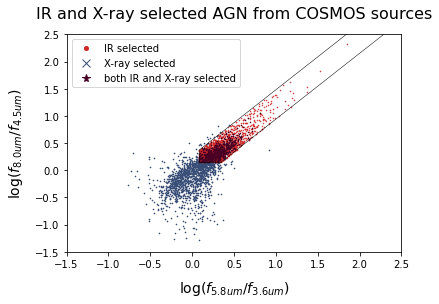

In [15]:
# plot data
plt.plot(x_ir, y_ir, '.', c=myP.c_ir, markersize=1, label='IR selected')
plt.plot(x_xr, y_xr, 'x', c=myP.c_xray, markersize=1, label='X-ray selected')
plt.plot(x_ix, y_ix, '*', c=myP.c_ir_xray, markersize=1, label='both IR and X-ray selected')

# draw box
myP.PlotDonleyWedge()

# customize
plt.axis([-1.5,2.5,-1.5,2.5]) 
plt.legend(markerscale=8)
plt.title('IR and X-ray selected AGN from COSMOS sources') 

# display
plt.savefig(path_fig+'\COSMOS_IR-Xray_selection.png',bbox_inches ="tight",pad_inches=0.2,facecolor='w',edgecolor='w')
plt.show()